In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
import ngboost as ngb
from sklearn.metrics import mean_absolute_error

import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from scipy import sparse
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import ngboost as ngb
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import seaborn as sns

In [78]:
model = pd.read_csv('model.csv') #lon	lat	lev	time	dni
shortwave = pd.read_csv('shortwave.csv') #lon	lat	lev	time	dni
power = pd.read_csv('power.csv') #lon	lat	lev	time	pe

# 2. shortwave의 dni열의 데이터를 model에 매핑
model_df = model.merge(shortwave[['lon', 'lat', 'lev', 'time', 'dni']], 
                          on=['lon', 'lat', 'lev', 'time'], 
                          how='left')

# 3. power의 pe열의 데이터를 model에 매핑
model_df = model_df.merge(power[['lon', 'lat', 'lev', 'time', 'pe']], 
                          on=['lon', 'lat', 'lev', 'time'], 
                          how='left')

model_df = model_df.rename(columns={
    'dni_x': 'model',
    'dni_y': 'shortwave',
    'pe': 'power',
    'time': 'date',
    'lev': 'time',
    'lon': 'stn'
    # ... 추가로 변경하고 싶은 컬럼들을 계속 나열 ...
})

model_df.head()

stn   lat  time        date     model  shortwave     power
0  1.0  32.5   8.0  2020-04-01  776.0467  359.00027  0.326354
1  1.0  32.5   8.0  2020-04-02  779.1447  353.75003  0.352347
2  1.0  32.5   8.0  2020-04-03  783.5680  508.86197  0.351625
3  1.0  32.5   8.0  2020-04-04  831.6874  712.25020  0.405776
4  1.0  32.5   8.0  2020-04-05  606.8581  614.58340  0.389170

In [85]:
sub_df = model_df
sub_df.head()

stn   lat  time        date     model  shortwave     power
0  1.0  32.5   8.0  2020-04-01  776.0467  359.00027  0.326354
1  1.0  32.5   8.0  2020-04-02  779.1447  353.75003  0.352347
2  1.0  32.5   8.0  2020-04-03  783.5680  508.86197  0.351625
3  1.0  32.5   8.0  2020-04-04  831.6874  712.25020  0.405776
4  1.0  32.5   8.0  2020-04-05  606.8581  614.58340  0.389170

In [87]:
sub_df['datetime'] = pd.to_datetime(sub_df['date'] + ' ' + sub_df['time'].astype(int).astype(str) + ':00:00')
sub_df = sub_df.sort_values(by=['stn','datetime'])
sub_df.head()

stn   lat  time        date      model  shortwave     power   
0    1.0  32.5   8.0  2020-04-01  776.04670  359.00027  0.326354  \
118  1.0  32.5   9.0  2020-04-01  826.18140  478.58370  0.507581   
236  1.0  32.5  10.0  2020-04-01  831.46344  381.36755  0.535018   
354  1.0  32.5  11.0  2020-04-01  419.56903  386.78336  0.644765   
472  1.0  32.5  12.0  2020-04-01  273.90598  454.09793  0.730686   

               datetime  
0   2020-04-01 08:00:00  
118 2020-04-01 09:00:00  
236 2020-04-01 10:00:00  
354 2020-04-01 11:00:00  
472 2020-04-01 12:00:00

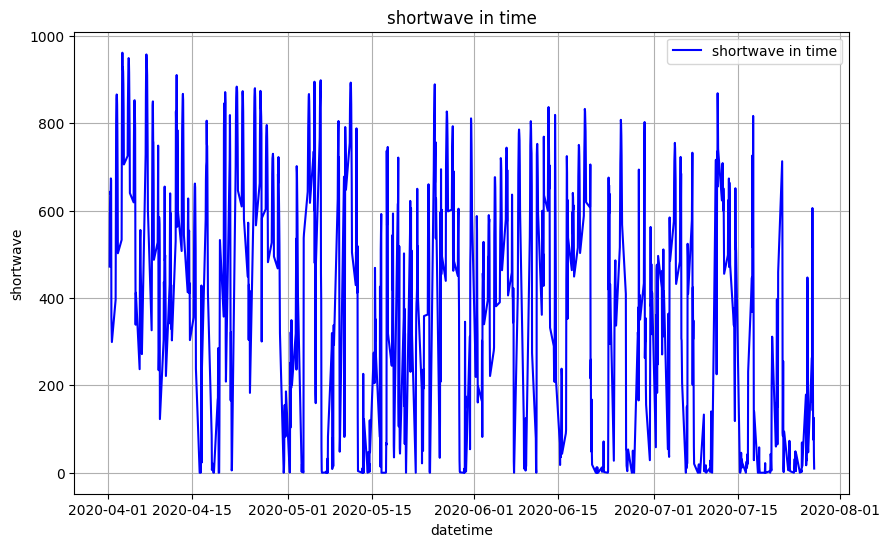

In [75]:
# 같은 datetime에 대해 shortwave의 평균값 계산
grouped = sub_df.groupby('datetime').agg({'shortwave': 'mean'}).reset_index()

plt.figure(figsize = (10,6))
plt.plot(grouped['datetime'], grouped['shortwave'], label='shortwave in time', color='blue')
plt.title('shortwave in time')
plt.xlabel('datetime')
plt.ylabel('shortwave')
plt.legend()
plt.grid(True)
plt.show()


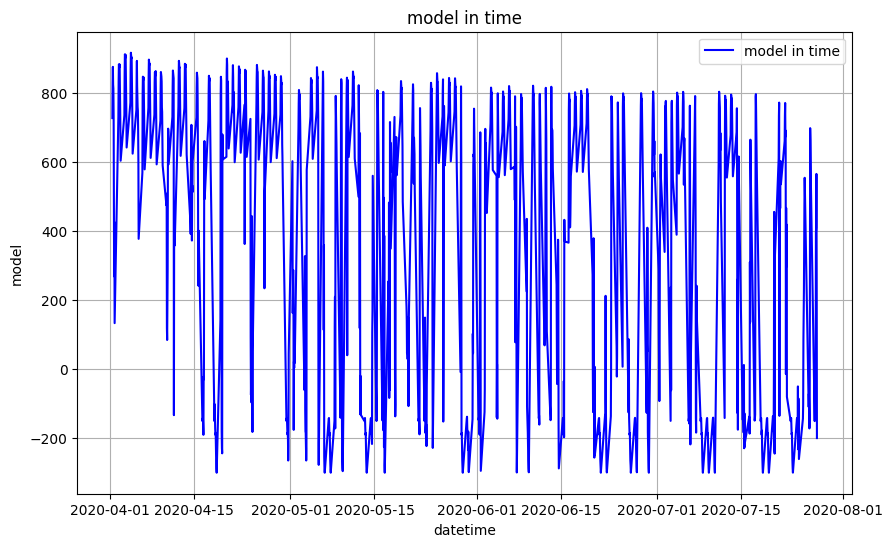

In [76]:
# 같은 datetime에 대해 shortwave의 평균값 계산
grouped = sub_df.groupby('datetime').agg({'model': 'mean'}).reset_index()

plt.figure(figsize = (10,6))
plt.plot(grouped['datetime'], grouped['model'], label='model in time', color='blue')
plt.title('model in time')
plt.xlabel('datetime')
plt.ylabel('model')
plt.legend()
plt.grid(True)
plt.show()


In [88]:
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import LogScore
from ngboost.learners import default_tree_learner
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# NGBRegressor 설정
ngb = NGBRegressor(
    Dist=Normal,
    Score=LogScore,
    Base=default_tree_learner,
    natural_gradient=True,
    n_estimators=500,
    learning_rate=0.01,
    minibatch_frac=1.0,
    col_sample=1.0,
    verbose=True,
    verbose_eval=100,
    tol=1e-4,
    random_state=None
)

[iter 0] loss=-0.8614 val_loss=0.0000 scale=1.0000 norm=0.5195
[iter 100] loss=-0.8660 val_loss=0.0000 scale=2.0000 norm=1.0370
[iter 200] loss=-0.8702 val_loss=0.0000 scale=1.0000 norm=0.5176
[iter 300] loss=-0.8749 val_loss=0.0000 scale=1.0000 norm=0.5161
[iter 400] loss=-0.8798 val_loss=0.0000 scale=1.0000 norm=0.5143
	Completed model, and mae is : 0.12388870365934691
	Completed model, and mae is : 0.11513645656181752


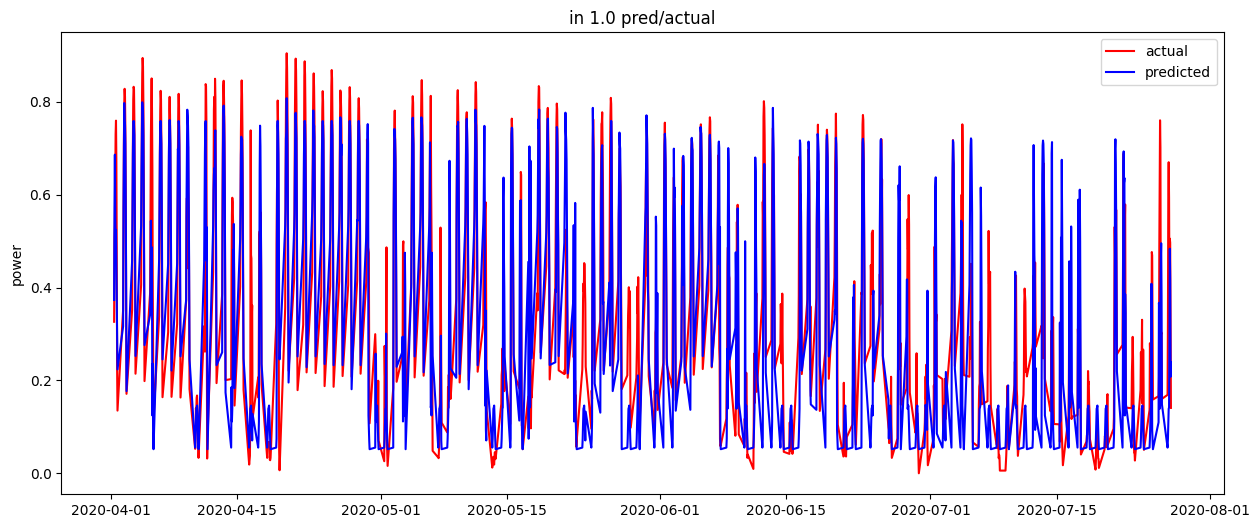

[]
	Completed model, and mae is : 0.1331006330224823


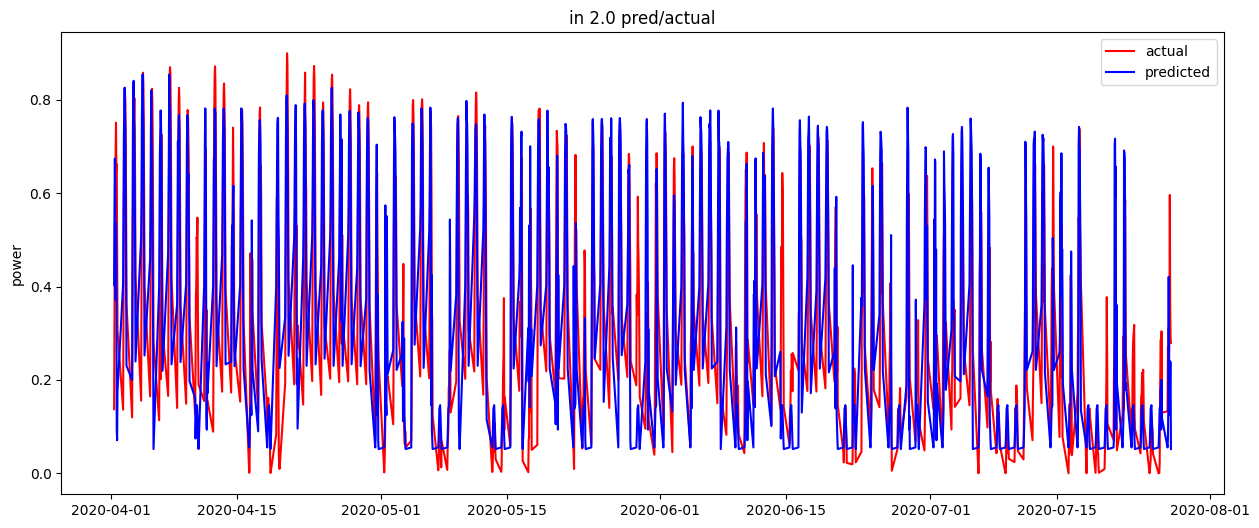

[]
	Completed model, and mae is : 0.12361003570851331


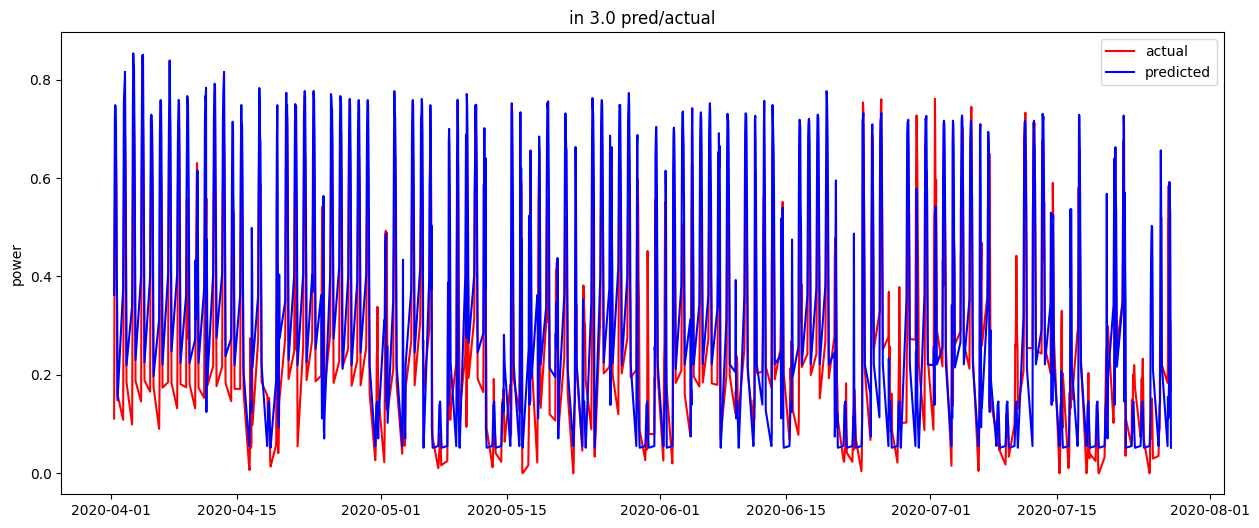

[]
	Completed model, and mae is : 0.11319203102317868


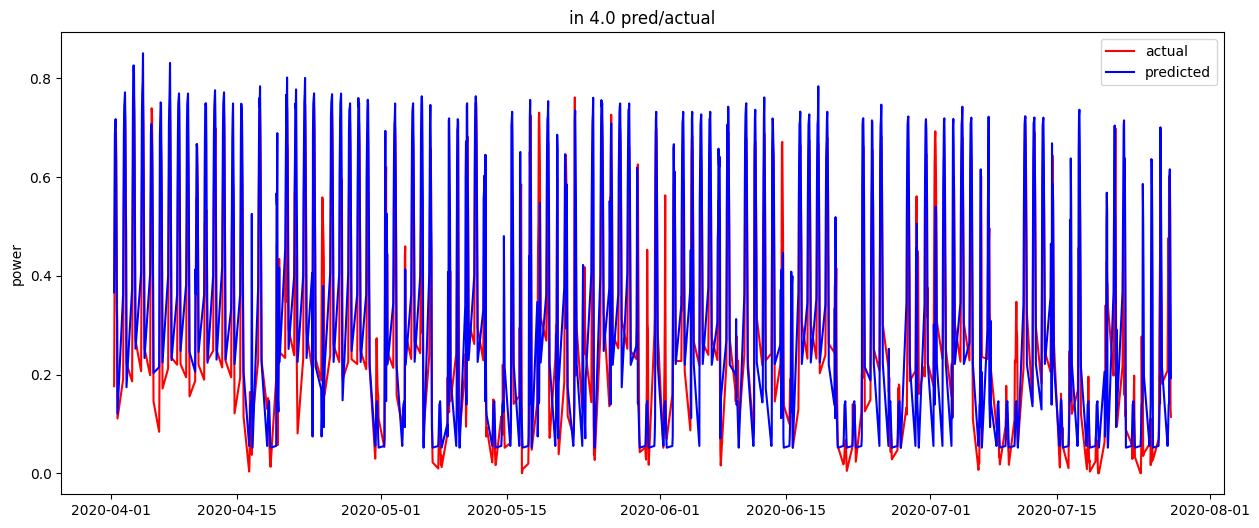

[]
	Completed model, and mae is : 0.09946718537220132


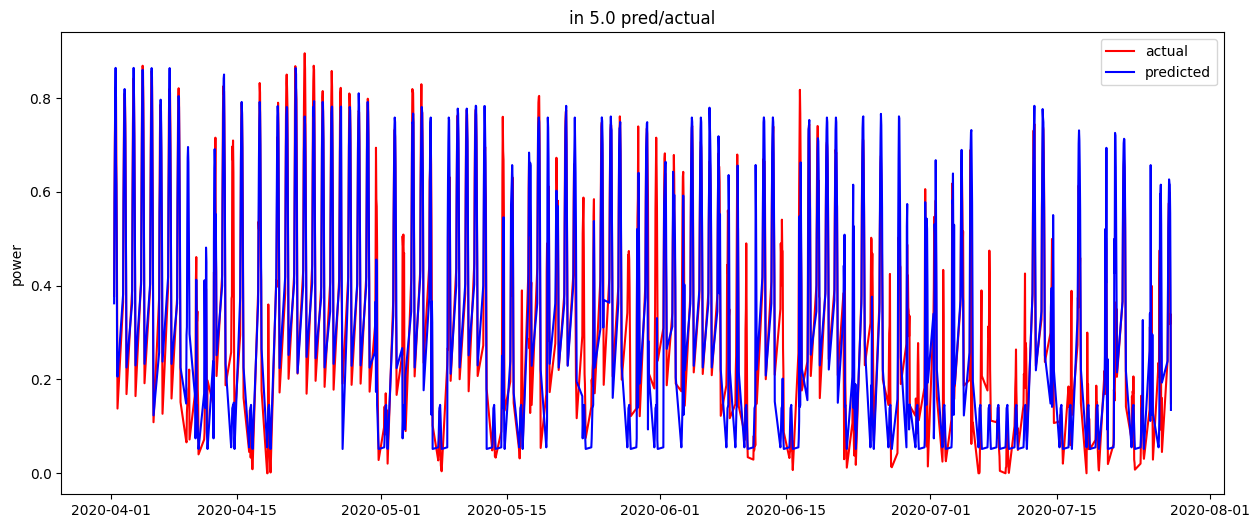

[]
	Completed model, and mae is : 0.12404612674008758


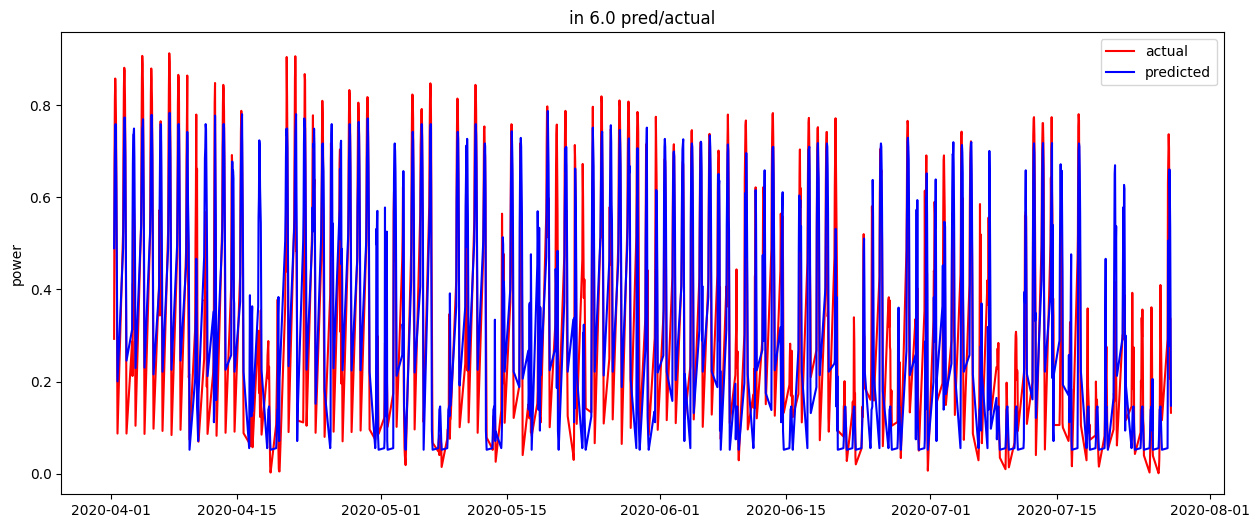

[]
	Completed model, and mae is : 0.11826754880279089


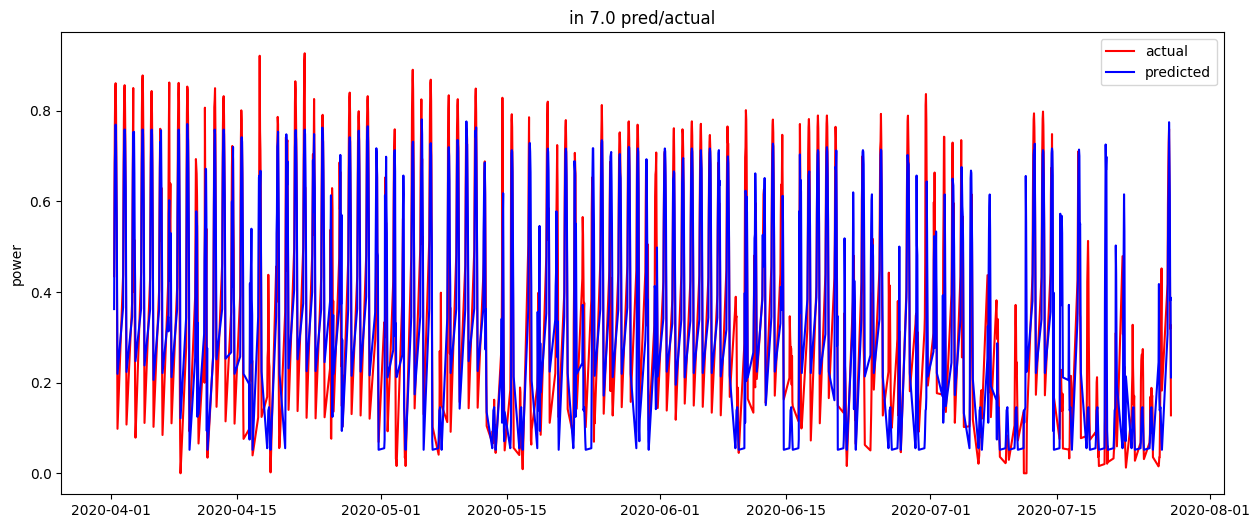

[]
	Completed model, and mae is : 0.1642896120437036


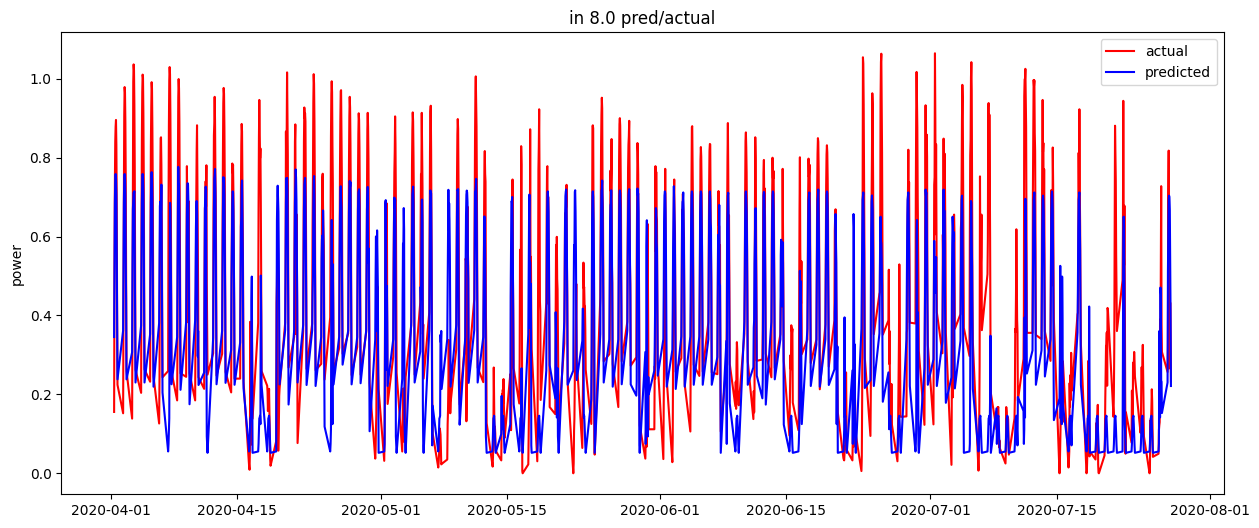

[]


In [93]:
# Evaluation Metrics

sub_df.sort_values(by=['stn', 'datetime'], inplace = True)


X = sub_df[['time', 'shortwave']]
y = sub_df['power']
X_test = sub_df[['time', 'model']]
y_test = sub_df['power']

X = X.values
y = y.values
X_test = X_test.values
y_test = y_test.values
    

stn_values = sub_df['stn'].unique()
stn_mae = []


model = ngb
model.fit(X, y, early_stopping_rounds = 25)
preds = model.predict(X_test)
sub_df['pred'] = preds
mae = mean_absolute_error(y_test, preds)
print(f"\tCompleted model, and mae is : {mae}")

for location in stn_values:
    location_data = sub_df[sub_df['stn']==location]
    
    pred = location_data['pred']
    actual = location_data['power']
    
    mae = mean_absolute_error(actual, pred)
    print(f"\tCompleted model, and mae is : {mae}")
    
    plt.figure(figsize=(15,6))
    plt.plot(location_data['datetime'], actual, label = 'actual', color = 'red')
    plt.plot(location_data['datetime'], pred, label = 'predicted', color = 'blue')
    plt.title(f"in {location} pred/actual")
    plt.ylabel('power')
    plt.legend()
    plt.show()
    print(f"{stn_mae}")

In [91]:
sub_df.head(50)

stn   lat  time        date      model  shortwave     power   
0     1.0  32.5   8.0  2020-04-01  776.04670  359.00027  0.326354  \
118   1.0  32.5   9.0  2020-04-01  826.18140  478.58370  0.507581   
236   1.0  32.5  10.0  2020-04-01  831.46344  381.36755  0.535018   
354   1.0  32.5  11.0  2020-04-01  419.56903  386.78336  0.644765   
472   1.0  32.5  12.0  2020-04-01  273.90598  454.09793  0.730686   
590   1.0  32.5  13.0  2020-04-01  323.54398  585.44500  0.759567   
708   1.0  32.5  14.0  2020-04-01  314.69153  560.36120  0.671480   
826   1.0  32.5  15.0  2020-04-01  217.42700  434.06726  0.477978   
944   1.0  32.5  16.0  2020-04-01  332.68040  375.70178  0.225993   
1062  1.0  32.5  17.0  2020-04-01  605.49310  256.21793  0.135018   
1     1.0  32.5   8.0  2020-04-02  779.14470  353.75003  0.352347   
119   1.0  32.5   9.0  2020-04-02  827.77954  505.52786  0.558845   
237   1.0  32.5  10.0  2020-04-02  833.26874  596.30554  0.707581   
355   1.0  32.5  11.0  2020-04-02  853.15356  652.08325  0.795668   
473   1.0  32.5  12.0  2020-04-02  850.46370  754.61140  0.828159   
591   1.0  32.5  13.0  2020-04-02  842.47500  749.38930  0.811552   
709   1.0  32.5  14.0  2020-04-02  852.42900  711.50037  0.738628   
827   1.0  32.5  15.0  2020-04-02  806.76685  668.36150  0.602166   
945   1.0  32.5  16.0  2020-04-02  748.05300  577.08374  0.404332   
1063  1.0  32.5  17.0  2020-04-02  667.93940  426.08356  0.171119   
2     1.0  32.5   8.0  2020-04-03  783.56800  508.86197  0.351625   
120   1.0  32.5   9.0  2020-04-03  827.80930  625.44570  0.536462   
238   1.0  32.5  10.0  2020-04-03  829.89300  697.00037  0.706859   
356   1.0  32.5  11.0  2020-04-03  849.09937  776.91550  0.805054   
474   1.0  32.5  12.0  2020-04-03  846.49930  817.02630  0.832491   
592   1.0  32.5  13.0  2020-04-03  848.54456  863.58136  0.827437   
710   1.0  32.5  14.0  2020-04-03  867.94770  876.88806  0.758123   
828   1.0  32.5  15.0  2020-04-03  835.93207  844.36040  0.636101   
946   1.0  32.5  16.0  2020-04-03  785.46270  775.33295  0.454874   
1064  1.0  32.5  17.0  2020-04-03  714.87550  628.86070  0.214440   
3     1.0  32.5   8.0  2020-04-04  831.68740  712.25020  0.405776   
121   1.0  32.5   9.0  2020-04-04  871.80444  838.02783  0.620939   
239   1.0  32.5  10.0  2020-04-04  874.52430  895.30524  0.773285   
357   1.0  32.5  11.0  2020-04-04  893.27500  928.19446  0.862094   
475   1.0  32.5  12.0  2020-04-04  888.71100  929.00006  0.894585   
593   1.0  32.5  13.0  2020-04-04  872.58520  925.88885  0.876534   
711   1.0  32.5  14.0  2020-04-04  884.88153  907.99980  0.795668   
829   1.0  32.5  15.0  2020-04-04  839.35980  849.94460  0.654874   
947   1.0  32.5  16.0  2020-04-04  783.04126  763.11100  0.453430   
1065  1.0  32.5  17.0  2020-04-04  710.49054  525.14014  0.198556   
4     1.0  32.5   8.0  2020-04-05  606.85810  614.58340  0.389170   
122   1.0  32.5   9.0  2020-04-05  473.35507  738.36120  0.584116   
240   1.0  32.5  10.0  2020-04-05  504.48187  763.02795  0.723466   
358   1.0  32.5  11.0  2020-04-05  178.89612  755.06570  0.801444   
476   1.0  32.5  12.0  2020-04-05  216.48955  769.76776  0.850541   
594   1.0  32.5  13.0  2020-04-05  138.20744  672.23114  0.781227   
712   1.0  32.5  14.0  2020-04-05  -56.30272  584.25040  0.657040   
830   1.0  32.5  15.0  2020-04-05   49.45733  363.79074  0.391336   
948   1.0  32.5  16.0  2020-04-05 -128.71872  233.90030  0.246931   
1066  1.0  32.5  17.0  2020-04-05 -135.96852  137.19548  0.116968   

                datetime      pred  
0    2020-04-01 08:00:00  0.372837  
118  2020-04-01 09:00:00  0.570960  
236  2020-04-01 10:00:00  0.686368  
354  2020-04-01 11:00:00  0.571894  
472  2020-04-01 12:00:00  0.507142  
590  2020-04-01 13:00:00  0.522963  
708  2020-04-01 14:00:00  0.478369  
826  2020-04-01 15:00:00  0.366267  
944  2020-04-01 16:00:00  0.309104  
1062 2020-04-01 17:00:00  0.226022  
1    2020-04-02 08:00:00  0.372837  
119  2020-04-02 09:00:00  0.570960  
237  

[iter 0] loss=-1.2704 val_loss=0.0000 scale=1.0000 norm=0.3790
[iter 100] loss=-1.4450 val_loss=0.0000 scale=1.0000 norm=0.4152
[iter 200] loss=-1.5155 val_loss=0.0000 scale=2.0000 norm=0.8961
[iter 300] loss=-1.5587 val_loss=0.0000 scale=1.0000 norm=0.4585
[iter 400] loss=-1.5910 val_loss=0.0000 scale=1.0000 norm=0.4631
	Completed model, and mae is : 0.12377421028387381
[iter 0] loss=0.8868 val_loss=0.0000 scale=1.0000 norm=2.6890
[iter 100] loss=-1.1629 val_loss=0.0000 scale=1.0000 norm=0.4703
[iter 200] loss=-1.2635 val_loss=0.0000 scale=1.0000 norm=0.4556
[iter 300] loss=-1.3091 val_loss=0.0000 scale=1.0000 norm=0.4576
[iter 400] loss=-1.3415 val_loss=0.0000 scale=1.0000 norm=0.4581
	Completed model, and mae is : 0.11014021305114155
[iter 0] loss=-0.3549 val_loss=0.0000 scale=1.0000 norm=1.4576
[iter 100] loss=-1.2871 val_loss=0.0000 scale=1.0000 norm=0.4879
[iter 200] loss=-1.3781 val_loss=0.0000 scale=1.0000 norm=0.4699
[iter 300] loss=-1.4253 val_loss=0.0000 scale=1.0000 norm=0.

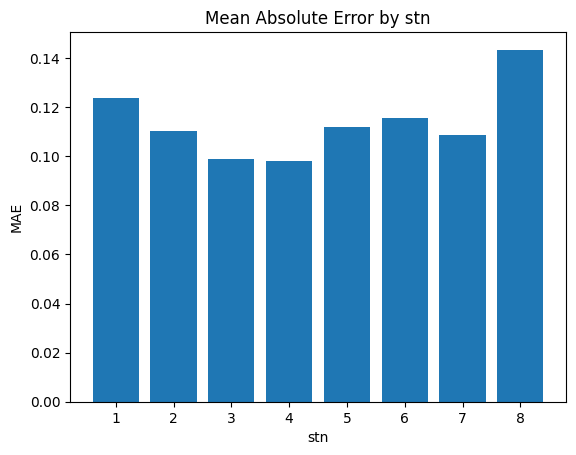

[0.12377421028387381, 0.11014021305114155, 0.09894573563731025, 0.0978738588458203, 0.11180930292552234, 0.11560595055737166, 0.108832655880442, 0.14337362440044435]


In [58]:
main()

[iter 0] loss=-0.8079 val_loss=0.0000 scale=1.0000 norm=0.5742
[iter 100] loss=-1.2322 val_loss=0.0000 scale=1.0000 norm=0.3978
[iter 200] loss=-1.3610 val_loss=0.0000 scale=1.0000 norm=0.4292
[iter 300] loss=-1.4257 val_loss=0.0000 scale=1.0000 norm=0.4592
[iter 400] loss=-1.4663 val_loss=0.0000 scale=1.0000 norm=0.4752


C:\Users\sedag\AppData\Local\Temp\ipykernel_25852\3925011579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].astype(int).astype(str) + ':00:00')


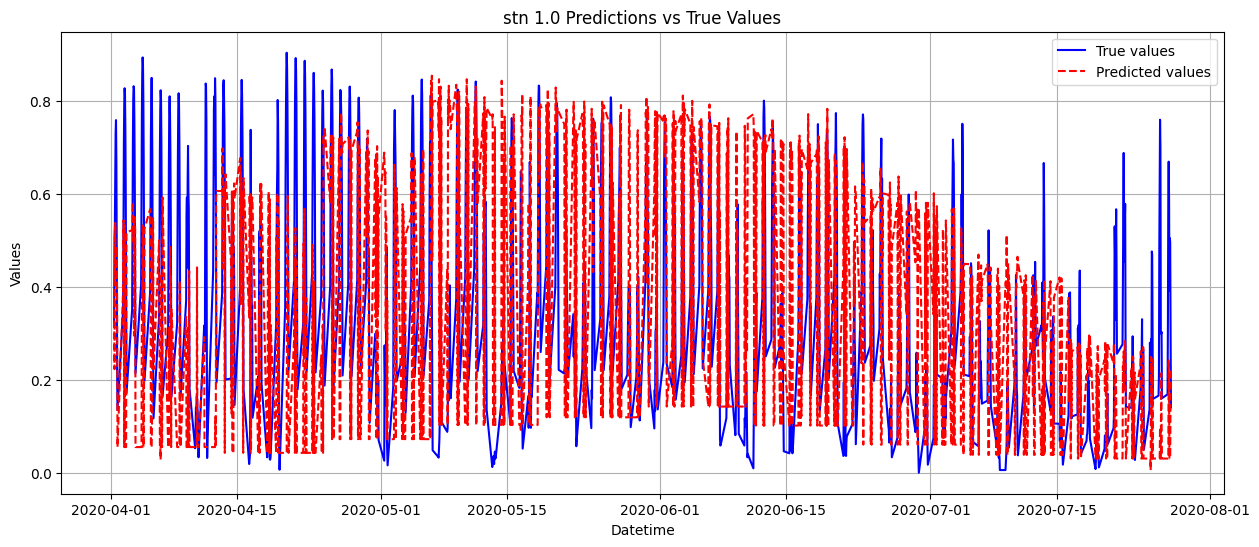

[iter 0] loss=1.0073 val_loss=0.0000 scale=1.0000 norm=2.7220
[iter 100] loss=-1.1243 val_loss=0.0000 scale=1.0000 norm=0.4636
[iter 200] loss=-1.2299 val_loss=0.0000 scale=1.0000 norm=0.4482
[iter 300] loss=-1.2744 val_loss=0.0000 scale=1.0000 norm=0.4537
[iter 400] loss=-1.3036 val_loss=0.0000 scale=1.0000 norm=0.4563


C:\Users\sedag\AppData\Local\Temp\ipykernel_25852\3925011579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].astype(int).astype(str) + ':00:00')


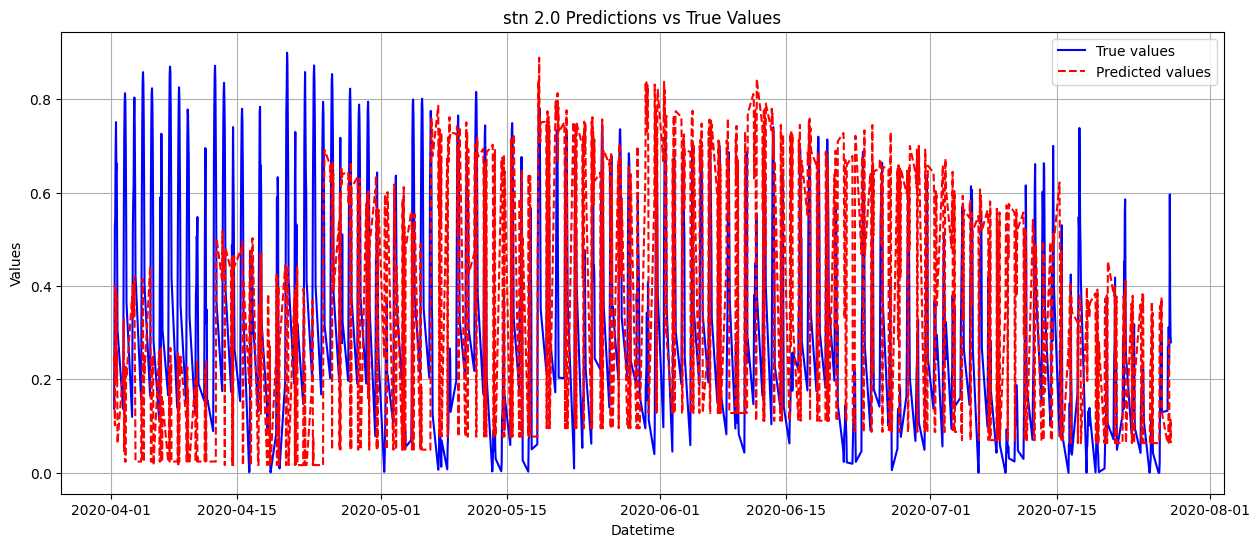

[iter 0] loss=-0.4087 val_loss=0.0000 scale=1.0000 norm=1.3597
[iter 100] loss=-1.2602 val_loss=0.0000 scale=1.0000 norm=0.4728
[iter 200] loss=-1.3446 val_loss=0.0000 scale=1.0000 norm=0.4555
[iter 300] loss=-1.3853 val_loss=0.0000 scale=1.0000 norm=0.4608
[iter 400] loss=-1.4138 val_loss=0.0000 scale=1.0000 norm=0.4628


C:\Users\sedag\AppData\Local\Temp\ipykernel_25852\3925011579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].astype(int).astype(str) + ':00:00')


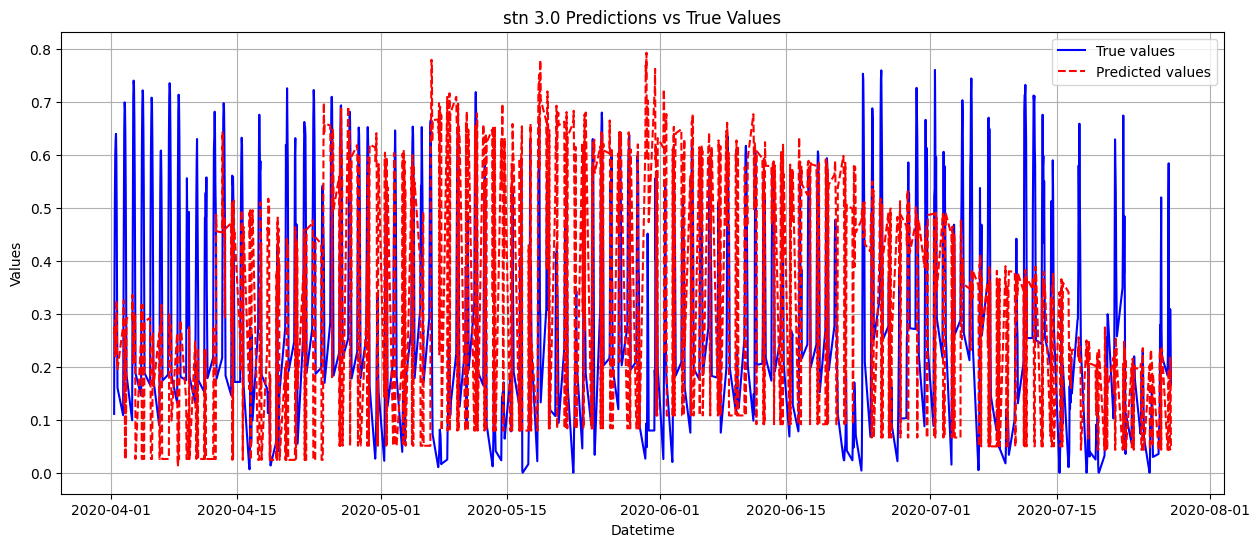

[iter 0] loss=-1.2873 val_loss=0.0000 scale=1.0000 norm=0.5341
[iter 100] loss=-1.5078 val_loss=0.0000 scale=1.0000 norm=0.4236
[iter 200] loss=-1.5692 val_loss=0.0000 scale=1.0000 norm=0.4319
[iter 300] loss=-1.6241 val_loss=0.0000 scale=1.0000 norm=0.4358
[iter 400] loss=-1.6620 val_loss=0.0000 scale=1.0000 norm=0.4378


C:\Users\sedag\AppData\Local\Temp\ipykernel_25852\3925011579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].astype(int).astype(str) + ':00:00')


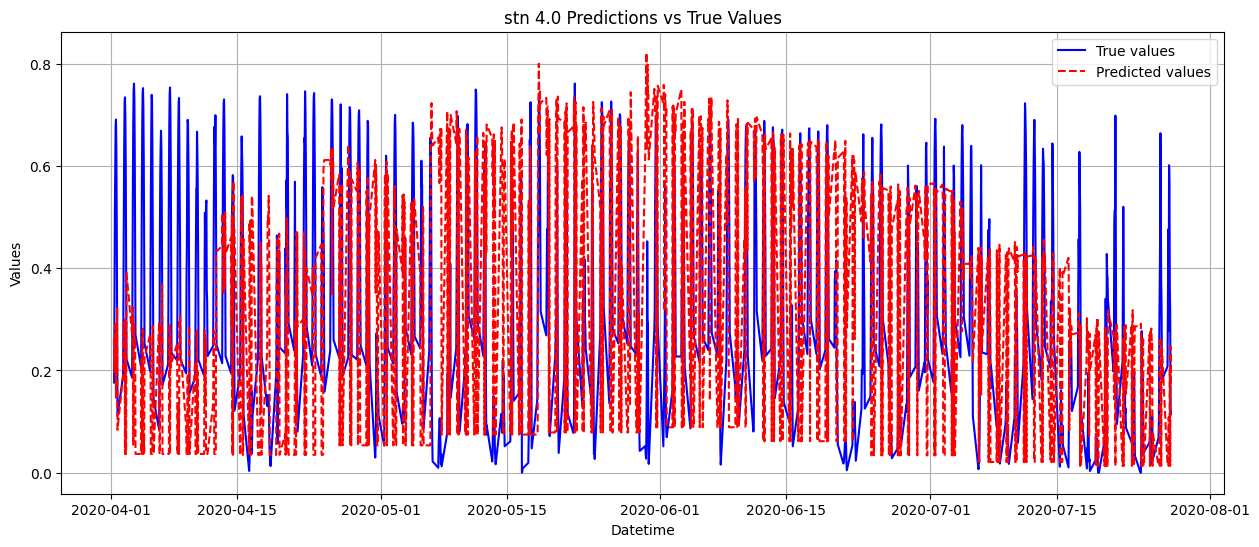

[iter 0] loss=-0.4868 val_loss=0.0000 scale=1.0000 norm=1.3748
[iter 100] loss=-1.3817 val_loss=0.0000 scale=1.0000 norm=0.4560
[iter 200] loss=-1.4556 val_loss=0.0000 scale=1.0000 norm=0.4531
[iter 300] loss=-1.4911 val_loss=0.0000 scale=1.0000 norm=0.4633
[iter 400] loss=-1.5236 val_loss=0.0000 scale=1.0000 norm=0.4656


C:\Users\sedag\AppData\Local\Temp\ipykernel_25852\3925011579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].astype(int).astype(str) + ':00:00')


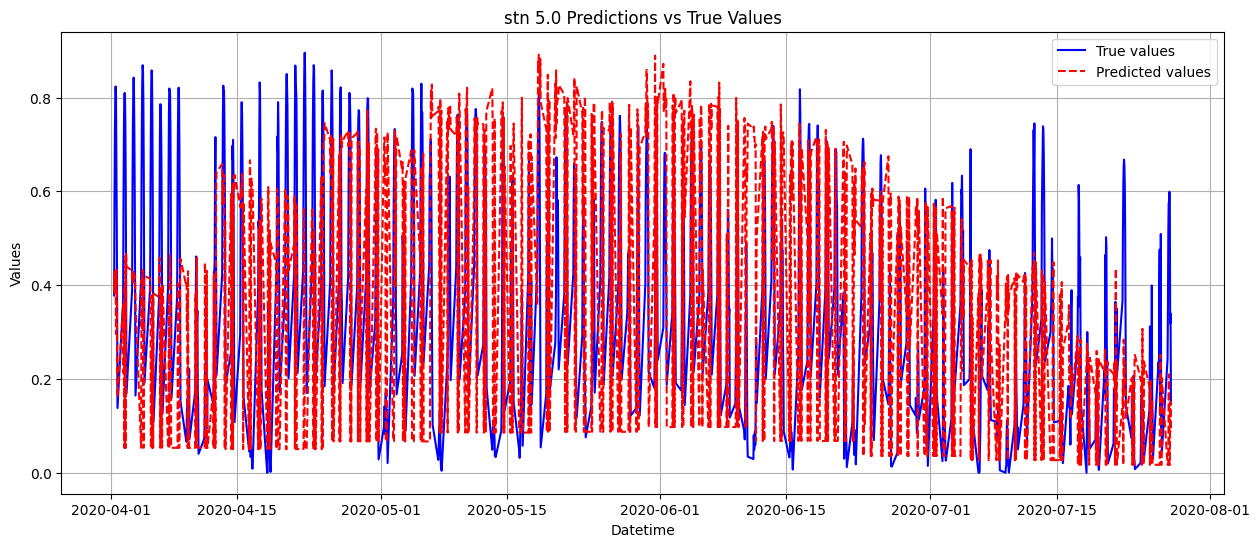

[iter 0] loss=-0.7545 val_loss=0.0000 scale=1.0000 norm=1.1057
[iter 100] loss=-1.3725 val_loss=0.0000 scale=1.0000 norm=0.4797
[iter 200] loss=-1.4383 val_loss=0.0000 scale=1.0000 norm=0.4664
[iter 300] loss=-1.4762 val_loss=0.0000 scale=1.0000 norm=0.4641
[iter 400] loss=-1.5078 val_loss=0.0000 scale=1.0000 norm=0.4600


C:\Users\sedag\AppData\Local\Temp\ipykernel_25852\3925011579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].astype(int).astype(str) + ':00:00')


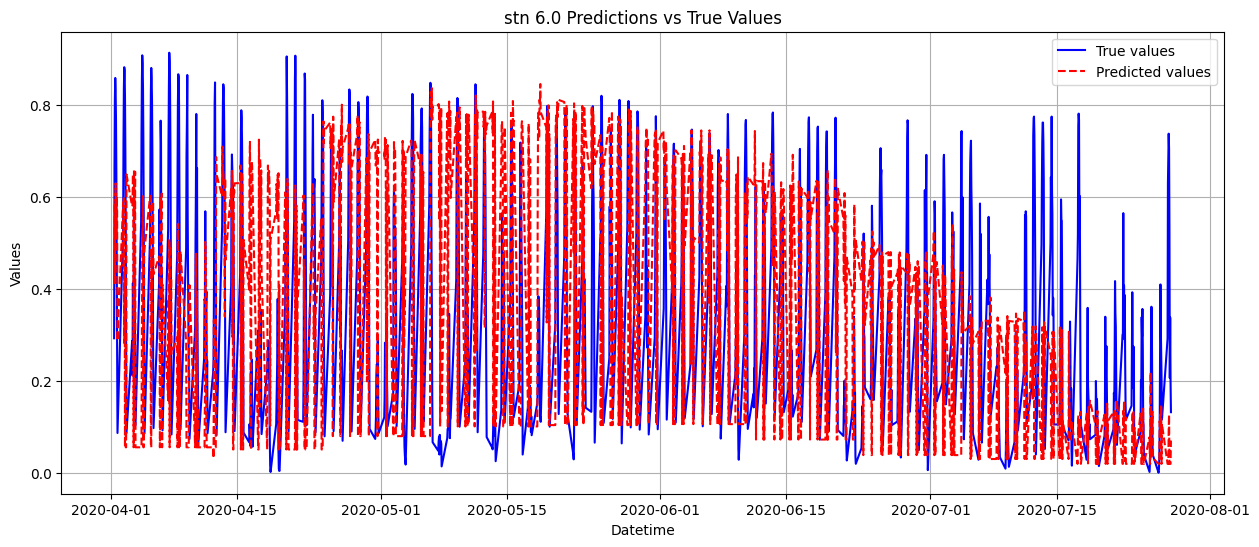

[iter 0] loss=-1.3477 val_loss=0.0000 scale=1.0000 norm=0.6014
[iter 100] loss=-1.4774 val_loss=0.0000 scale=1.0000 norm=0.4766
[iter 200] loss=-1.5161 val_loss=0.0000 scale=1.0000 norm=0.4586
[iter 300] loss=-1.5481 val_loss=0.0000 scale=1.0000 norm=0.4514
[iter 400] loss=-1.5752 val_loss=0.0000 scale=1.0000 norm=0.4461


C:\Users\sedag\AppData\Local\Temp\ipykernel_25852\3925011579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].astype(int).astype(str) + ':00:00')


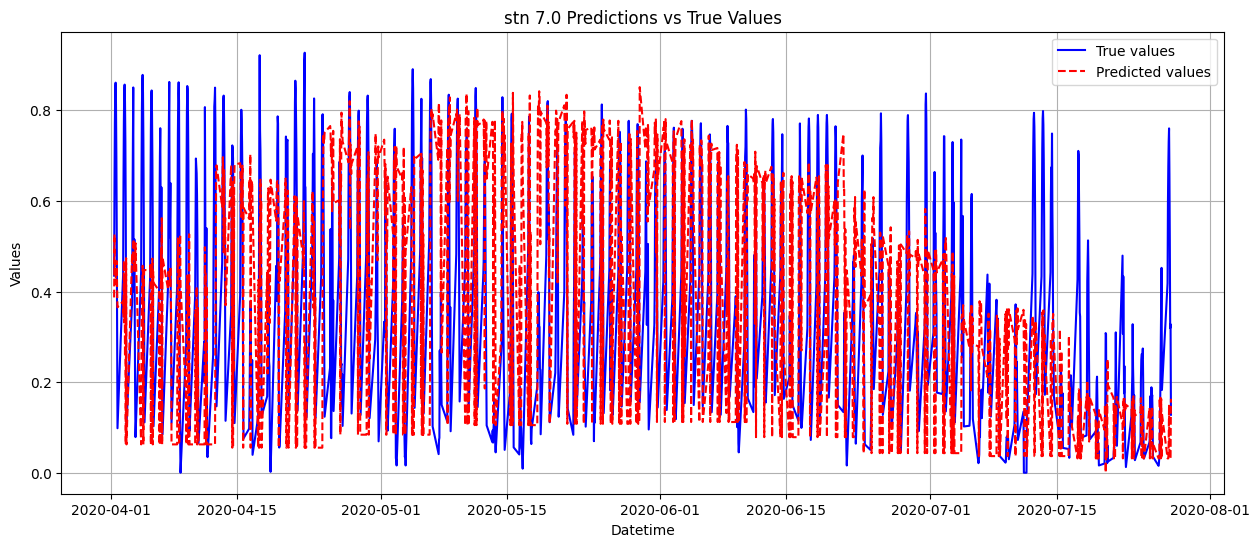

[iter 0] loss=2.4862 val_loss=0.0000 scale=1.0000 norm=4.0124
[iter 100] loss=-0.6041 val_loss=0.0000 scale=1.0000 norm=0.5701
[iter 200] loss=-0.6453 val_loss=0.0000 scale=1.0000 norm=0.5161
[iter 300] loss=-0.6583 val_loss=0.0000 scale=0.5000 norm=0.2498
[iter 400] loss=-0.6693 val_loss=0.0000 scale=0.5000 norm=0.2446


C:\Users\sedag\AppData\Local\Temp\ipykernel_25852\3925011579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].astype(int).astype(str) + ':00:00')


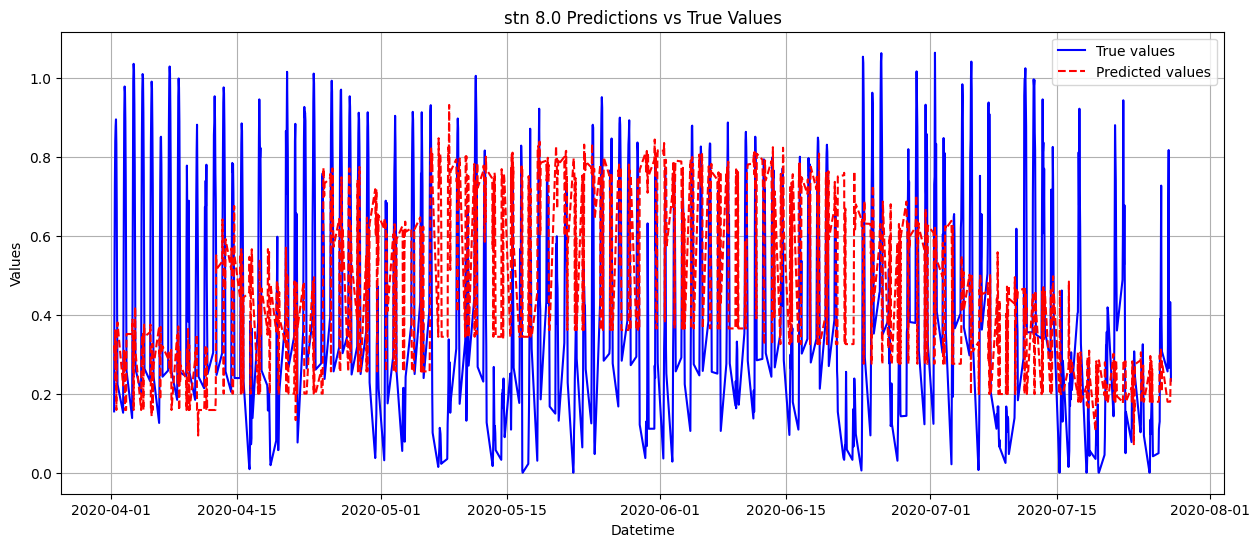

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_graph(stn, df, predictions):
    plt.figure(figsize=(15, 6))
    
    # x 축 데이터 생성 (date와 time 합치기)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].astype(int).astype(str) + ':00:00')
    df = df.sort_values(by='datetime')
    x_data = df['datetime']
    
    # y 축 데이터
    y_true = df['power']
    y_pred = predictions
    
    plt.plot(x_data, y_true, label="True values", color='blue')
    plt.plot(x_data, y_pred, label="Predicted values", color='red', linestyle='--')
    
    plt.title(f'stn {stn} Predictions vs True Values')
    plt.xlabel('Datetime')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    stn_values = model_df['stn'].unique()
    
    for stn in stn_values:
        sub_df = model_df[model_df['stn'] == stn]
        X, y, X_test, y_test = preprocess_data(stn)

        model = ngb
        model.fit(X, y, early_stopping_rounds = 25)
        predictions = model.predict(X_test)

        plot_graph(stn, sub_df, predictions)

# 실행
main()